In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import silhouette_score
from sklearn.utils import resample
import joblib

In [32]:
df = pd.read_csv('../data/processed/cleaned.csv')

In [33]:
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [34]:
df.isnull().sum()

Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64

#### Recency calculation (basically recency is the days since last purchase)

In [35]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])   
max_date = df['InvoiceDate'].max()
max_date

Timestamp('2011-12-09 12:50:00')

In [36]:
df['Recency'] = (max_date - df['InvoiceDate']).dt.days
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,738
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,738
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,738


#### Frequency Calculation (Number of invoices)

In [37]:
df['Frequency'] = df.groupby('Customer ID')['Invoice'].transform('nunique')

In [38]:
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,738,8
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,738,8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,738,8


#### Monetary Calculation (Total Spending of the Customer)

In [39]:
df['Monetary'] = df['Quantity'] * df['Price']
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Monetary
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,738,8,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,738,8,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,738,8,30.0


In [40]:
#log transform Monetary to reduce skewness
df['Monetary'] = np.log1p(df['Monetary'])
df.head(5)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Monetary
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,738,8,4.435567
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8,4.406719
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8,4.406719
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,738,8,4.623010
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,738,8,3.433987


In [41]:
# Scale RFM values
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
rfm_scaled_df.head()

,Recency,Frequency,Monetary
0,1.803196,-0.384191,1.953523
1,1.803196,-0.384191,1.924785
2,1.803196,-0.384191,1.924785
3,1.803196,-0.384191,2.140247
4,1.803196,-0.384191,0.955783


In [42]:
rfm_scaled_df.shape

(776686, 3)

k=2, WCSS=1748867.19
k=3, WCSS=1166131.23
k=4, WCSS=900728.48
k=5, WCSS=738970.34
k=6, WCSS=614725.91
k=7, WCSS=589877.64
k=8, WCSS=490044.30
k=9, WCSS=439510.15
k=10, WCSS=415838.94


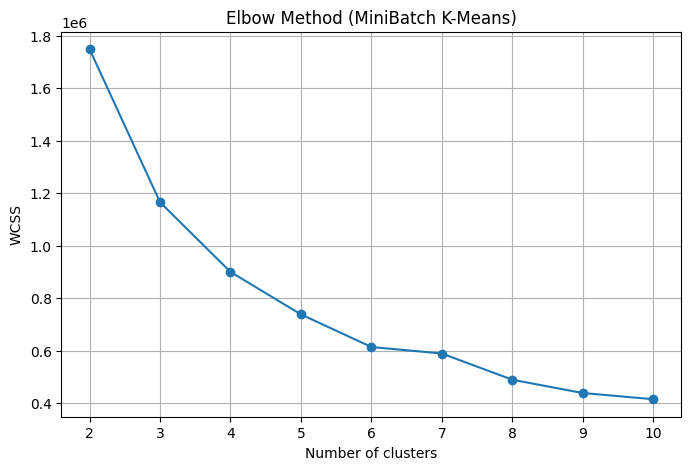

In [43]:
wcss = []
K_range = range(2, 11)

for k in K_range:
    mbk = MiniBatchKMeans(
        n_clusters=k,
        batch_size=4096,
        random_state=42,
        n_init=10
    )
    mbk.fit(rfm_scaled_df)
    wcss.append(mbk.inertia_)
    print(f'k={k}, WCSS={mbk.inertia_:.2f}')

plt.figure(figsize=(8, 5))
plt.plot(K_range, wcss, marker='o')
plt.title('Elbow Method (MiniBatch K-Means)')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid()
plt.show()


k=2, silhouette=0.3103
k=3, silhouette=0.3523
k=4, silhouette=0.3139
k=5, silhouette=0.3569
k=6, silhouette=0.3275
k=7, silhouette=0.3308
k=8, silhouette=0.3515
k=9, silhouette=0.3485
k=10, silhouette=0.3441


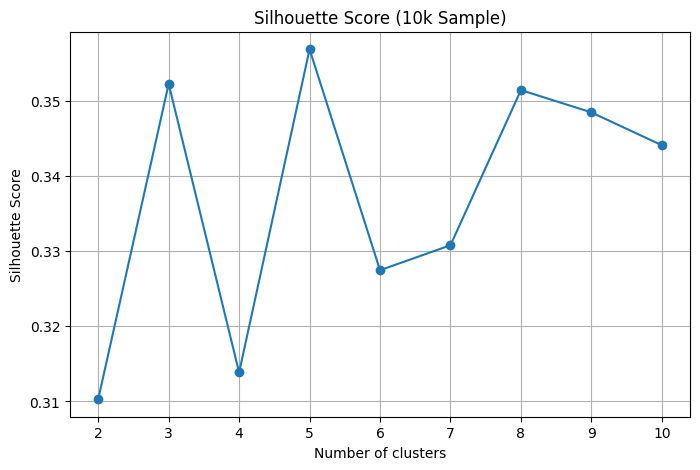

In [44]:
# 10k sample is MORE than enough
sample_df = resample(
    rfm_scaled_df,
    n_samples=10000,
    random_state=42
)

silhouette_scores = []

for k in range(2, 11):
    mbk = MiniBatchKMeans(
        n_clusters=k,
        batch_size=2048,
        random_state=42,
        n_init=10
    )
    labels = mbk.fit_predict(sample_df)

    score = silhouette_score(sample_df, labels)
    silhouette_scores.append(score)

    print(f'k={k}, silhouette={score:.4f}')

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score (10k Sample)')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid()
plt.show()


In [45]:
final_kmeans = MiniBatchKMeans(
    n_clusters=5,
    batch_size=4096,
    random_state=42,
    n_init=10
)

final_kmeans.fit(rfm_scaled_df)


,n_clusters,5
,init,'k-means++'
,max_iter,100
,batch_size,4096
,verbose,0
,compute_labels,True
,random_state,42
,tol,0.0
,max_no_improvement,10
,init_size,None
,n_init,10


In [46]:
df['Cluster'] = final_kmeans.labels_

In [47]:
df

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Recency,Frequency,Monetary,Cluster
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,738,8,4.435567,4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8,4.406719,4
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,738,8,4.406719,4
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,738,8,4.623010,0
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,738,8,3.433987,4
...,...,...,...,...,...,...,...,...,...,...,...,...
776681,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,0,4,2.415914,2
776682,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,0,4,2.610070,2
776683,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,0,4,2.867899,2
776684,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,0,4,2.867899,2


In [48]:
customer_rfm = df.groupby('Customer ID').agg({
    'Recency': 'min',
    'Frequency': 'max',
    'Monetary': 'sum',
    'Cluster': 'first'
}).reset_index()

In [49]:
customer_rfm

,Customer ID,Recency,Frequency,Monetary,Cluster
0,12346.0,325,12,87.715523,4
1,12347.0,1,8,659.078320,4
2,12348.0,74,5,148.997711,4
3,12349.0,18,3,512.631572,4
4,12350.0,309,1,46.829722,4
...,...,...,...,...,...
5859,18283.0,3,22,1124.132377,1
5860,18284.0,431,1,73.309589,4
5861,18285.0,660,1,33.322284,4
5862,18286.0,476,2,190.894284,4


In [50]:
cluster_profile = customer_rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Customer ID': 'count'
}).rename(columns={'Customer ID': 'CustomerCount'})

cluster_profile


,Recency,Frequency,Monetary,CustomerCount
Cluster,,,,
0,197.419549,7.242105,274.844507,665
1,242.381242,5.878197,355.163334,821
2,75.617472,2.444444,141.701869,1179
3,0.500000,250.666667,15391.436083,6
4,236.060758,7.082994,372.111725,3193


In [51]:
cluster_map = {
    0: 'At-Risk Customers',   # High Recency, High Frequency: Used to visit often but haven't returned in ~200 days. Needs re-engagement.
    1: 'Lost Customers',      # Highest Recency, Lowest Frequency/Monetary: Haven't shopped in a long time with minimal spend. Low priority.
    2: 'New Customers',       # Low Recency, Low Frequency: Recent first-time buyers. Opportunity to nurture into Regulars.
    3: 'VIP Customers',       # Lowest Recency, Highest Frequency & Spend: Your most valuable 'Whales'. Drive the majority of revenue.
    4: 'Regular Customers'    # Moderate Recency & Frequency: Steady shoppers who provide consistent baseline revenue.
}

customer_rfm['ClusterLabel'] = customer_rfm['Cluster'].map(cluster_map)


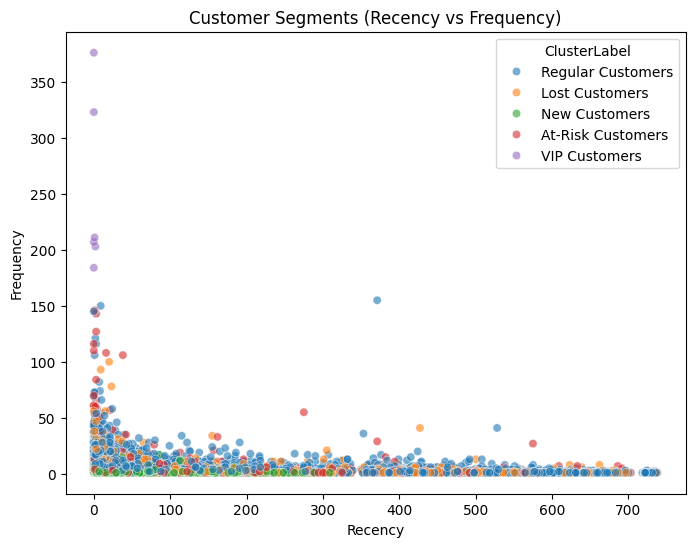

In [54]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_rfm,
    x='Recency',
    y='Frequency',
    hue='ClusterLabel',
    palette='tab10',
    alpha=0.6
)
plt.title('Customer Segments (Recency vs Frequency)')
plt.show()


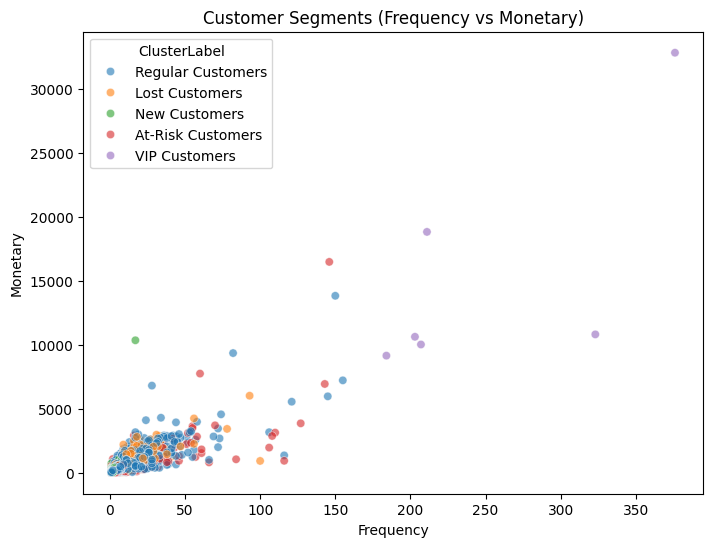

In [55]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=customer_rfm,
    x='Frequency',
    y='Monetary',
    hue='ClusterLabel',
    palette='tab10',
    alpha=0.6
)
plt.title('Customer Segments (Frequency vs Monetary)')
plt.show()


In [53]:
joblib.dump(final_kmeans, '../models/kmeans_rfm.pkl')
joblib.dump(scaler, '../models/rfm_scaler.pkl')
customer_rfm.to_csv('../data/processed/customer_segments.csv', index=False)